## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_simple_network, Flatten, weight_reset, moveTo

<ipython-input-1-26952118aea9>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else device)

Tesla T4


## Excercise 1
Modify LanguageNameDataset so the vocabulary object in the constructor does not need to be passed in as an argument but instead can be inferred from the input dataset.

In [ ]:
class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary=None):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        
        if vocabulary is None:
            vocabulary = self.__vocab_from_data(lang_name_dict)
        
        self.vocabulary = vocabulary

        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
    
    def __vocab_from_data(self, lang_name_dict):
        vocabulary = {}
        tokens = set()
        for samples in lang_name_dict.values():
            for sample in samples:
                tokens |= set(sample)
        for i, token in enumerate(tokens):
            vocabulary[token] = i
        return vocabulary
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

## Excercise 2
Update LanguageNameDataset with a flag in the constructor for unicode=False

### LanguageNameDataset

In [3]:
import unicodedata
import string

class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary=None, unicode=False):
        lang_name_dict = self.__normalize_data(lang_name_dict, unicode)
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.unicode = unicode
        
        if vocabulary is None:
            vocabulary = self.__vocab_from_data(lang_name_dict)
        
        self.vocabulary = vocabulary

        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
    
    def __normalize_data(self, lang_name_dict, unicode):
        normalized = {}
        
        for lang, samples in lang_name_dict.items():
            normalized[lang] = [sample.lower() if unicode else self.unicodeToAscii(sample).lower()
                                for sample in samples]
        return normalized
        
    
    def __vocab_from_data(self, lang_name_dict):
        vocabulary = {}
        tokens = set()
        for samples in lang_name_dict.values():
            for sample in samples:
                tokens |= set(sample)

        for i, token in enumerate(tokens):
            vocabulary[token] = i
 
        return vocabulary
    
    def unicodeToAscii(self, s):
        all_letters = string.ascii_letters + " .,;'"

        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in all_letters
        )
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        if self.unicode == False:
            input_string = self.unicodeToAscii(input_string)

        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

### Training

In [3]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

name_language_data = {}
#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [line for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            name_language_data[lang] = lang_names

In [5]:
from idlmam import train_simple_network, LastTimeStep, EmbeddingPackable, pad_and_pack
from random import randint

def do_rnn_training(name_language_data, unicode=False, batch_size=1, random_seed = 42):
    dataset = LanguageNameDataset(name_language_data, unicode=unicode)

    # see https://stackoverflow.com/a/65717266/2120382
    train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300), generator=torch.Generator().manual_seed(random_seed))
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_and_pack)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_and_pack)

    D = 64
    vocab_size = len(dataset.vocabulary)
    hidden_nodes = 256
    classes = len(dataset.label_names)

    rnn_model = nn.Sequential(
      EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
      nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
      LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
      nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
    )


    loss_func = nn.CrossEntropyLoss()
    results = train_simple_network(rnn_model, loss_func, train_loader, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)
    return rnn_model, results, dataset

In [6]:
from random import randint
random_seed = randint(-10**9, 10**9)
random_seed

526552174

In [7]:
ascii_model, ascii_res, ascii_ds = do_rnn_training(name_language_data, unicode=False, batch_size=16, random_seed=random_seed)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

In [8]:
unicode_model, unicode_res, unicode_ds = do_rnn_training(name_language_data, unicode=True, batch_size=16, random_seed=random_seed)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

In [9]:
print(f'Ascii vocab size = {len(ascii_ds.vocabulary)}')
print(f'Unicode vocab size = {len(unicode_ds.vocabulary)}')

Ascii vocab size = 29
Unicode vocab size = 58


<Axes: xlabel='epoch', ylabel='test Accuracy'>

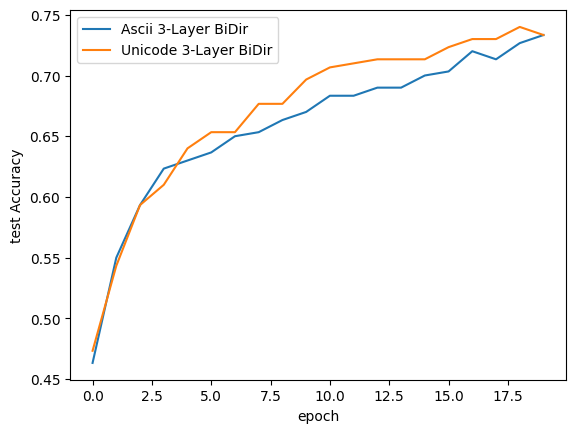

In [10]:
sns.lineplot(x='epoch', y='test Accuracy', data=ascii_res, label='Ascii 3-Layer BiDir')
sns.lineplot(x='epoch', y='test Accuracy', data=unicode_res, label='Unicode 3-Layer BiDir')

In [11]:
ascii_ds = LanguageNameDataset(name_language_data, unicode=False)
ascii_pred_rnn = ascii_model.to("cpu").eval()
with torch.no_grad():
    preds = F.softmax(ascii_pred_rnn(ascii_ds.string2InputVec("jürgen").reshape(1,-1)), dim=-1)
pd.DataFrame(preds.T*100, index=ascii_ds.label_names, columns=['%']).sort_values(['%'], ascending=False).head(5)

%
English  46.158340
Russian  28.633476
German   12.252013
Dutch     3.543936
French    2.358371

In [12]:
unicode_pred_rnn = unicode_model.to("cpu").eval()
with torch.no_grad():
    preds = F.softmax(unicode_pred_rnn(unicode_ds.string2InputVec("jürgen").reshape(1,-1)), dim=-1)
pd.DataFrame(preds.T*100, index=unicode_ds.label_names, columns=['%']).sort_values(['%'], ascending=False).head(5)

%
English  54.838978
German   15.887713
Russian  13.139532
Dutch     6.034320
Irish     2.386392

### Conclusions
Using Unicode symbols increases vocabulary to 58 tokens. More information gives hints for neural network to better predict result. As a result
* accuracy is slightly better when using Unicode characters


## Excercise 3
Update LanguageNameDataset with a new min_count=1 argument in the constructor

### LanguageNameDataset

In [6]:
import unicodedata
import string
from collections import Counter

class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary=None, unicode=False, min_count=1):
        """
        Init new dataset

        Keyword arguments:
        min_count -- if vocabulary=None, it should replace any character that occurs too few times with a special "UNK" token, indicating an unknown value.

        """
        lang_name_dict = self.__normalize_data(lang_name_dict, unicode)
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.unicode = unicode
        
        if vocabulary is None:
            vocabulary = self.__vocab_from_data(lang_name_dict, min_count)
        
        self.vocabulary = vocabulary

        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
    
    def __normalize_data(self, lang_name_dict, unicode):
        normalized = {}
        
        for lang, samples in lang_name_dict.items():
            normalized[lang] = [sample.lower() if unicode else self.unicodeToAscii(sample).lower()
                                for sample in samples]
        return normalized
        
    
    def __vocab_from_data(self, lang_name_dict, min_count):
        vocabulary = {}
        tokens = Counter()
        for samples in lang_name_dict.values():
            for sample in samples:
                tokens.update(sample)

        for i, (token, total) in enumerate(tokens.items(), 1):
            # if total is less than min_count, encode with 0 as UNK
            vocabulary[token] = i if total >= min_count else 0
 
        return vocabulary
    
    def unicodeToAscii(self, s):
        all_letters = string.ascii_letters + " .,;'"

        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in all_letters
        )
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        if self.unicode == False:
            input_string = self.unicodeToAscii(input_string)

        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

### Training

In [14]:
def do_rnn_training(name_language_data, unicode=False, min_count=1, batch_size=16, random_seed = 42):
    dataset = LanguageNameDataset(name_language_data, unicode=unicode, min_count=min_count)

    # see https://stackoverflow.com/a/65717266/2120382
    train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300), generator=torch.Generator().manual_seed(random_seed))
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_and_pack)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_and_pack)

    D = 64
    vocab_size = len(dataset.vocabulary)
    hidden_nodes = 256
    classes = len(dataset.label_names)

    rnn_model = nn.Sequential(
      EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
      nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
      LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
      nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
    )


    loss_func = nn.CrossEntropyLoss()
    results = train_simple_network(rnn_model, loss_func, train_loader, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)
    return rnn_model, results, dataset

In [15]:
ascii_model_min_300, ascii_res_min_300, ascii_ds_min_300 = do_rnn_training(name_language_data, unicode=False, min_count=300, batch_size=16, random_seed=random_seed)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

In [16]:
unicode_model_min_300, unicode_res_min_300, unicode_ds_min_300 = do_rnn_training(name_language_data, unicode=True, min_count=300, batch_size=16, random_seed=random_seed)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

In [17]:
print(f'Ascii vocab size = {len(set(ascii_ds_min_300.vocabulary.values()))}')
print(f'Unicode vocab size = {len(set(unicode_ds_min_300.vocabulary.values()))}')

Ascii vocab size = 25
Unicode vocab size = 25


<Axes: xlabel='epoch', ylabel='test Accuracy'>

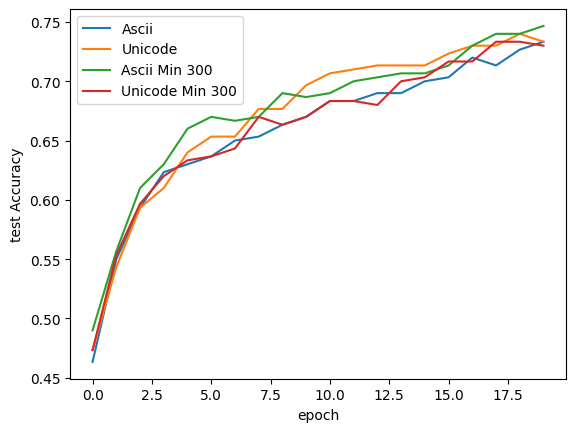

In [18]:
sns.lineplot(x='epoch', y='test Accuracy', data=ascii_res, label='Ascii')
sns.lineplot(x='epoch', y='test Accuracy', data=unicode_res, label='Unicode')
sns.lineplot(x='epoch', y='test Accuracy', data=ascii_res_min_300, label='Ascii Min 300')
sns.lineplot(x='epoch', y='test Accuracy', data=unicode_res_min_300, label='Unicode Min 300')

### Conclusions
* for Unicode vocabulary, setting rare characters (frequency < 300) to same code greatly decreased vocabulary size from 58 to 25. As a result, lots of symbols was replaced by the same code. This seems to be the reason why it showed the worst results. But in the end, it still converged to almost the same accuracy as in other scenarios
* for Ascii vocab, with `min_count=300`, vocabulary size was not reduced much, from 29 to 25. And this time, it showed the best results in accuracy. Probably, this way noise in data was reduced.


## Excercise 4
Create your own function that performs stratified splitting

### stratified_split

In [7]:
import random
from collections import defaultdict

def stratified_split(dataset, lengths, random_seed=42):
    random.seed(random_seed)
    train_len, test_len = lengths

    train_fraction = train_len / (train_len + test_len)

    train_indices = list()
    test_indices = list()

    label_to_indices = defaultdict(list)
    for index, label in enumerate(dataset.labels):
        label_to_indices[label].append(index)

    for label, indices in label_to_indices.items():
        train_samples_len = round(train_fraction*len(indices))

        train = random.sample(indices, train_samples_len)
        test = set(indices) - set(train)

        train_indices.extend(train)
        test_indices.extend(test)

    return torch.utils.data.Subset(dataset, train_indices), torch.utils.data.Subset(dataset, test_indices)

### Training

In [8]:
def do_rnn_training(name_language_data, unicode=False, min_count=1, batch_size=16, random_seed = 42):
    dataset = LanguageNameDataset(name_language_data, unicode=unicode, min_count=min_count)

    # use statified split
    train_data, test_data = stratified_split(dataset, (len(dataset)-300, 300))
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_and_pack)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_and_pack)

    D = 64
    vocab_size = len(dataset.vocabulary)
    hidden_nodes = 256
    classes = len(dataset.label_names)

    rnn_model = nn.Sequential(
      EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
      nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
      LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
      nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
    )


    loss_func = nn.CrossEntropyLoss()
    results = train_simple_network(rnn_model, loss_func, train_loader, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)
    return rnn_model, results, dataset

In [9]:
ascii_model_stratified, ascii_res_stratified, ascii_ds_stratified = do_rnn_training(name_language_data, unicode=False, min_count=300, batch_size=16, random_seed=random_seed)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

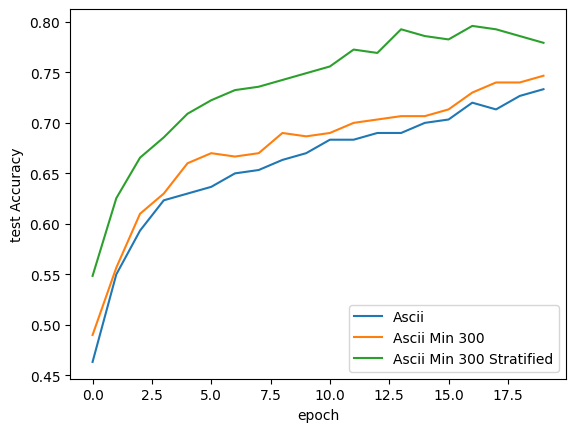

In [36]:
sns.lineplot(x='epoch', y='test Accuracy', data=ascii_res, label='Ascii')
sns.lineplot(x='epoch', y='test Accuracy', data=ascii_res_min_300, label='Ascii Min 300')
sns.lineplot(x='epoch', y='test Accuracy', data=ascii_res_stratified, label='Ascii Min 300 Stratified')

### Conclusion
With Stratified split, test dataset better represents the input dataset, as a result the accuracy greatly increased.

## Excersice 5
Replace the last output layer nn.Linear(hidden_nodes, classes) from the RNN implementation with a fully connected network

In [37]:
def do_rnn_training(name_language_data, unicode=False, min_count=1, batch_size=16, random_seed = 42):
    dataset = LanguageNameDataset(name_language_data, unicode=unicode, min_count=min_count)

    # use statified split
    train_data, test_data = stratified_split(dataset, (len(dataset)-300, 300))
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_and_pack)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_and_pack)

    D = 64
    vocab_size = len(dataset.vocabulary)
    hidden_nodes = 256
    classes = len(dataset.label_names)

    rnn_model = nn.Sequential(
      EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
      nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
      LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)

      # two hidden layers and one output layer
      nn.Linear(hidden_nodes*2,  hidden_nodes*2), #(B, D) -> (B, D)
      nn.Tanh(),
      nn.Linear(hidden_nodes*2,  hidden_nodes*2), #(B, D) -> (B, D)
      nn.Tanh(),
      nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
    )


    loss_func = nn.CrossEntropyLoss()
    results = train_simple_network(rnn_model, loss_func, train_loader, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)
    return rnn_model, results, dataset

In [38]:
ascii_model_fully_conn, ascii_res_fully_conn, ascii_ds_fully_conn = do_rnn_training(name_language_data, unicode=False, min_count=300, batch_size=16, random_seed=random_seed)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

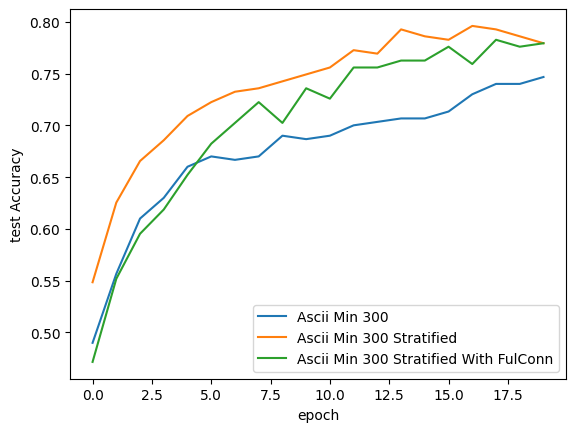

In [40]:
sns.lineplot(x='epoch', y='test Accuracy', data=ascii_res_min_300, label='Ascii Min 300')
sns.lineplot(x='epoch', y='test Accuracy', data=ascii_res_stratified, label='Ascii Min 300 Stratified')
sns.lineplot(x='epoch', y='test Accuracy', data=ascii_res_fully_conn, label='Ascii Min 300 Stratified With FulConn')

### Conclusion
Accuracy decreased after adding a fully connected network at the end of RNN. It seems that adding more hidden layers in the end makes it harder for RNN to converge to better accuracy.

## Execsice 6
Implement your own collate_fn that removes half the items from a batch of training data

### Custom `collate_fn`

In [10]:
def cut_half_and_pad_and_pack(batch):
    # remove half of batch items
    indices = random.sample(range(0, len(batch)), round(len(batch)/2))
    batch = [batch[i] for i in indices]
    
    #1, 2, & 3: organize the batch input lengths, inputs, and outputs as seperate lists
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)
    #4: create the padded version of the input
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    #5: create the packed version from the padded & lengths
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=False, enforce_sorted=False)
    #Convert the lengths into a tensor
    y_batched = torch.as_tensor(labels, dtype=torch.long)
    #6: return a tuple of the packed inputs and their labels
    return x_packed, y_batched

### Training

In [11]:
def do_rnn_training(name_language_data, unicode=False, min_count=1, batch_size=16, random_seed = 42):
    dataset = LanguageNameDataset(name_language_data, unicode=unicode, min_count=min_count)

    # use statified split
    train_data, test_data = stratified_split(dataset, (len(dataset)-300, 300))
    # remove half the items from a batch of training data 
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=cut_half_and_pad_and_pack)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_and_pack)

    D = 64
    vocab_size = len(dataset.vocabulary)
    hidden_nodes = 256
    classes = len(dataset.label_names)

    rnn_model = nn.Sequential(
      EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
      nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
      LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
      nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
    )


    loss_func = nn.CrossEntropyLoss()
    results = train_simple_network(rnn_model, loss_func, train_loader, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=20)
    return rnn_model, results, dataset

In [12]:
ascii_model_half_batch, ascii_res_half_batch, ascii_ds_half_batch = do_rnn_training(name_language_data, unicode=False, min_count=300, batch_size=16, random_seed=random_seed)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

Training:   0%|          | 0/1236 [00:00<?, ?it/s]

Testing:   0%|          | 0/19 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

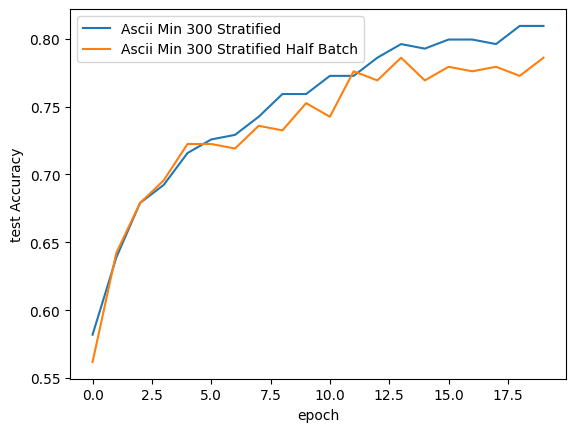

In [14]:
sns.lineplot(x='epoch', y='test Accuracy', data=ascii_res_stratified, label='Ascii Min 300 Stratified')
sns.lineplot(x='epoch', y='test Accuracy', data=ascii_res_half_batch, label='Ascii Min 300 Stratified Half Batch')

### Conclusion
According to results, accuracy **decreased** slightly, when half of the batch is ignored on each iteration. But training with 2 epochs of this new model gives better results that with old one where all batch rows are preserved.

I suppose that this related to
- after cutting half of the training set, there is still enough data to train model
- less training data leads to less fitting the train dataset and better represent the problem

## Exercise 7
Compare training a three-layer bidirectional RNN with batch sizes of $B = {1, 2, 4, 8}$ for five epochs

### Training

In [19]:
def do_rnn_training(name_language_data, unicode=False, min_count=1, batch_size=16, epochs=5, random_seed = 42):
    dataset = LanguageNameDataset(name_language_data, unicode=unicode, min_count=min_count)

    # use statified split
    train_data, test_data = stratified_split(dataset, (len(dataset)-300, 300))
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=pad_and_pack)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=pad_and_pack)

    D = 64
    vocab_size = len(dataset.vocabulary)
    hidden_nodes = 256
    classes = len(dataset.label_names)

    rnn_model = nn.Sequential(
      EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
      nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
      LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
      nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
    )


    loss_func = nn.CrossEntropyLoss()

    # training only 5 epochs
    results = train_simple_network(rnn_model, loss_func, train_loader, test_loader=test_loader, score_funcs={'Accuracy': accuracy_score}, device=device, epochs=epochs)
    return results

In [20]:
batch_size_to_epochs = {
    1: 5,
    2: 10,
    4: 15,
    8: 25
}

results = {}

for batch_size in [1, 2, 4, 8]:
  result = do_rnn_training(name_language_data, unicode=False, min_count=300, batch_size=batch_size, epochs=batch_size_to_epochs[batch_size], random_seed=random_seed)
  results[batch_size] = result

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/19775 [00:00<?, ?it/s]

Testing:   0%|          | 0/299 [00:00<?, ?it/s]

Training:   0%|          | 0/19775 [00:00<?, ?it/s]

Testing:   0%|          | 0/299 [00:00<?, ?it/s]

Training:   0%|          | 0/19775 [00:00<?, ?it/s]

Testing:   0%|          | 0/299 [00:00<?, ?it/s]

Training:   0%|          | 0/19775 [00:00<?, ?it/s]

Testing:   0%|          | 0/299 [00:00<?, ?it/s]

Training:   0%|          | 0/19775 [00:00<?, ?it/s]

Testing:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/9888 [00:00<?, ?it/s]

Testing:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/9888 [00:00<?, ?it/s]

Testing:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/9888 [00:00<?, ?it/s]

Testing:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/9888 [00:00<?, ?it/s]

Testing:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/9888 [00:00<?, ?it/s]

Testing:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/9888 [00:00<?, ?it/s]

Testing:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/9888 [00:00<?, ?it/s]

Testing:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/9888 [00:00<?, ?it/s]

Testing:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/9888 [00:00<?, ?it/s]

Testing:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/9888 [00:00<?, ?it/s]

Testing:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Training:   0%|          | 0/4944 [00:00<?, ?it/s]

Testing:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Training:   0%|          | 0/2472 [00:00<?, ?it/s]

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

<Axes: xlabel='total time', ylabel='test Accuracy'>

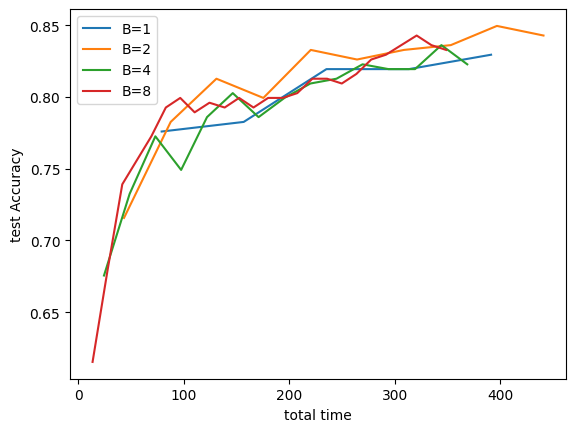

In [21]:
sns.lineplot(x='total time', y='test Accuracy', data=results[1], label='B=1')
sns.lineplot(x='total time', y='test Accuracy', data=results[2], label='B=2')
sns.lineplot(x='total time', y='test Accuracy', data=results[4], label='B=4')
sns.lineplot(x='total time', y='test Accuracy', data=results[8], label='B=8')

### Conclusion
My experiment showed that $B=2$ showed the best result when considering time spend on training. However, $B=8$ showed good results and overperformed in accuracy at several points in time.